In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [11]:
!pip install matplotlib

In [2]:
print(tf.__version__)

2.0.0


In [4]:
df = pd.read_csv('win_proba.csv')
df = df.drop_duplicates().sample(frac=1.0)
df['lead'] = df['home']-df['visitor']
df.head(10)

,game_id,home_team,away_team,home,visitor,net,time,win,lead
88028,401168258,Florida State,North Florida,8,4,19.8,2194,1,4
363196,401171635,San Diego,UC Davis,49,45,5.6,218,1,4
10611,401166071,Purdue,Chicago State,91,45,47.4,152,1,46
603094,401183488,St. John's,UMass,20,15,11.6,1820,1,5
567754,401175742,New Mexico State,UTEP,4,2,2.9,2218,1,2
187441,401169858,Tennessee,Chattanooga,50,36,18.9,376,1,14
106486,401168389,SMU,Georgetown,11,28,-5.3,1790,0,-17
617269,401187173,VCU,Tennessee,19,20,0.5,1714,0,-1
325581,401170866,Hartford,Sacred Heart,10,4,-9.7,2091,0,6
82114,401168239,Georgia Tech,Nebraska,46,37,4.7,781,1,9


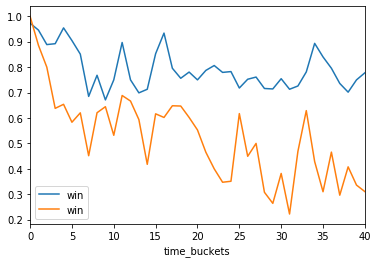

In [210]:
favorite = df[(df.lead >= 2) & (df.lead <= 4) & (df.net>=4) & (df.net<=6)].groupby(['time_buckets']).agg({'win': pd.Series.mean})
underdog = df[(df.lead >= 2) & (df.lead <= 4) & (df.net>=-6) & (df.net<=-4)].groupby(['time_buckets']).agg({'win': pd.Series.mean})
axes = favorite.plot()
underdog.plot(ax=axes)

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, activation='relu', input_shape=[3,]),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(df[['lead','net','time']].to_numpy(),
          df['win'].to_numpy(),
          verbose=1,
          shuffle=True,
          epochs=50,
          batch_size=256)

Train on 471185 samples
Epoch 1/50
471185/471185 [==============================] - 2s 4us/sample - loss: 1.2901 - accuracy: 0.8190 - AUC: 0.8441
Epoch 2/50
471185/471185 [==============================] - 1s 3us/sample - loss: 0.5563 - accuracy: 0.8362 - AUC: 0.8824
Epoch 3/50
471185/471185 [==============================] - 1s 3us/sample - loss: 0.4886 - accuracy: 0.8405 - AUC: 0.8919
Epoch 4/50
471185/471185 [==============================] - 1s 3us/sample - loss: 0.4342 - accuracy: 0.8442 - AUC: 0.8999
Epoch 5/50
471185/471185 [==============================] - 1s 3us/sample - loss: 0.3653 - accuracy: 0.8520 - AUC: 0.9114
Epoch 6/50
471185/471185 [==============================] - 1s 3us/sample - loss: 0.3375 - accuracy: 0.8557 - AUC: 0.9199
Epoch 7/50
471185/471185 [==============================] - 1s 3us/sample - loss: 0.3217 - accuracy: 0.8590 - AUC: 0.9244
Epoch 8/50
471185/471185 [==============================] - 1s 3us/sample - loss: 0.3090 - accuracy: 0.8621 - AUC: 0.9282


In [11]:
times = list(range(0,2400,30))
winp_favorite = [model.predict_proba(x=[[3,5,time]])[0][0] for time in times]
winp_underdog = [model.predict_proba(x=[[3,-5,time]])[0][0] for time in times]

In [18]:
model.predict_proba(x=[[3, -25, 30]])

array([[0.3534137]], dtype=float32)

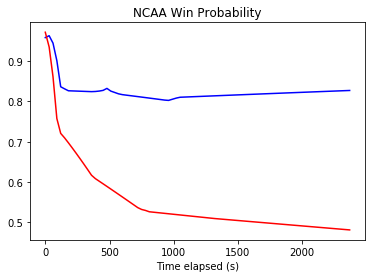

In [12]:
plt.plot(times, winp_favorite, 'b-')
plt.plot(times, winp_underdog, 'r-')
plt.title('NCAA Win Probability')
plt.xlabel('Time elapsed (s)')
plt.savefig('ncaa_win_prob-1-hidden-layer.png')

In [17]:
def transform(time):
    return 1/(1+np.exp(0.01*time))

def win_proba(lead, net, time, weights):
    return tf.math.sigmoid(weights[0][0][0]*lead + weights[0][1][0]*net + weights[0][2][0]*time + weights[1][0])

In [91]:
outcomes = pd.read_csv('win_prob_outcomes.csv')
outcomes['wp'] = outcomes.losses/outcomes.wins
outcomes.head()

,wins,losses,time_bin,min_time,max_time,wp
0,1338,569,1,2321,2400,0.425262
1,1338,569,2,2241,2320,0.425262
2,1339,569,3,2161,2240,0.424944
3,1339,569,4,2081,2160,0.424944
4,1338,568,5,2001,2080,0.424514


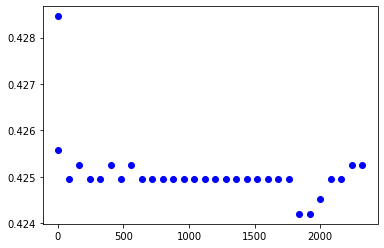

In [92]:
plt.plot(outcomes.min_time, outcomes.wp, 'bo')